# <span style="color:red"> Cat/Dog Classification

## <span style="color:blue"> 1.) Data Preparation/Preprocessing

### Uploading Data and Splitting training images into Validation and Training Sets

In [ ]:
import os
import shutil
import random


In [ ]:

def distribute_train_validation_split(validation_size=0.2):

    all_images = os.listdir('/Users/annemariedonohue/Desktop/Big data/input_from_kaggle/train')
    random.shuffle(all_images)

    all_dogs = list(filter(lambda image: 'dog' in image, all_images))
    all_cats = list(filter(lambda image: 'cat' in image, all_images))

    index_to_split = int(len(all_dogs) - len(all_dogs) * validation_size)
    training_dogs = all_dogs[:index_to_split]
    validation_dogs = all_dogs[index_to_split:]
    training_cats = all_cats[:index_to_split]
    validation_cats = all_cats[index_to_split:]

    shutil.rmtree('/Users/annemariedonohue/Desktop/Big data/input_for_model')
    os.makedirs('/Users/annemariedonohue/Desktop/Big data/input_for_model/train/dogs', exist_ok=True)
    os.makedirs('/Users/annemariedonohue/Desktop/Big data/input_for_model/train/cats', exist_ok=True)
    os.makedirs('/Users/annemariedonohue/Desktop/Big data/input_for_model/validation/dogs/', exist_ok=True)
    os.makedirs('/Users/annemariedonohue/Desktop/Big data/input_for_model/validation/cats/', exist_ok=True)

    copy_images_to_dir(training_dogs, '/Users/annemariedonohue/Desktop/Big data/input_for_model/train/dogs')
    copy_images_to_dir(validation_dogs, '/Users/annemariedonohue/Desktop/Big data/input_for_model/validation/dogs/')
    copy_images_to_dir(training_cats, '/Users/annemariedonohue/Desktop/Big data/input_for_model/train/cats')
    copy_images_to_dir(validation_cats, '/Users/annemariedonohue/Desktop/Big data/input_for_model/validation/cats')

def copy_images_to_dir(images_to_copy, destination):
    for image in images_to_copy:
        shutil.copyfile(f'/Users/annemariedonohue/Desktop/Big data/input_from_kaggle/train/{image}', f'{destination}/{image}')
distribute_train_validation_split(0.25)


In [ ]:
# plot cat photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
from matplotlib.pyplot import figure

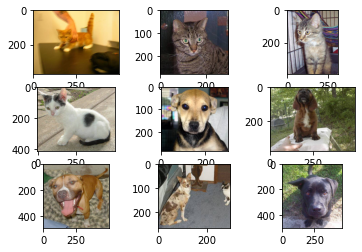

In [ ]:
# define location of dataset
folder = '/Users/annemariedonohue/Desktop/Big data/input_from_kaggle/train/'
    # plot first few images
for i in range(0,9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    if i < 4:
        filename = folder + 'cat.' + str(i) + '.jpg'
    else:
        filename = folder + 'dog.' + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
    #pyplot.imshow(image_dog)
# show the figure
pyplot.show()

### Preparing ImageDataGenerator for Image Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_imagedatagenerator = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_imagedatagenerator = ImageDataGenerator(rescale=1/255.0)

train_iterator = train_imagedatagenerator.flow_from_directory(
    '/Users/annemariedonohue/Desktop/Big data/input_for_model/train',
    target_size=(150, 150),
    batch_size=200,
    class_mode='binary')

validation_iterator = validation_imagedatagenerator.flow_from_directory(
    '/Users/annemariedonohue/Desktop/Big data/input_for_model/validation',
    target_size=(150, 150),
    batch_size=50,
    class_mode='binary')

Found 18750 images belonging to 2 classes.
Found 6250 images belonging to 2 classes.


In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('/Users/annemariedonohue/Desktop/Big data/input_for_model/train/cats/cat.14.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='/Users/annemariedonohue/Desktop/Big data/augmented', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break 

## <span style="color:blue"> 2.) Constructing Deep Learning Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.optimizers import SGD
from keras.losses import BinaryCrossentropy

In [ ]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPool2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

### Training Model

In [ ]:
history = model.fit(train_iterator,
                    validation_data = validation_iterator,
                    steps_per_epoch=93,
                    epochs=50,
                    validation_steps=125)

Epoch 1/50
93/93 [==============================] - 272s 3s/step - loss: 0.8301 - accuracy: 0.5188 - val_loss: 0.6283 - val_accuracy: 0.6394
Epoch 2/50
93/93 [==============================] - 281s 3s/step - loss: 0.6390 - accuracy: 0.6301 - val_loss: 0.5833 - val_accuracy: 0.6795
Epoch 3/50
93/93 [==============================] - 255s 3s/step - loss: 0.6081 - accuracy: 0.6685 - val_loss: 0.5459 - val_accuracy: 0.7272
Epoch 4/50
93/93 [==============================] - 218s 2s/step - loss: 0.5704 - accuracy: 0.6998 - val_loss: 0.5131 - val_accuracy: 0.7506
Epoch 5/50
93/93 [==============================] - 249s 3s/step - loss: 0.5656 - accuracy: 0.7048 - val_loss: 0.5031 - val_accuracy: 0.7526
Epoch 6/50
93/93 [==============================] - 262s 3s/step - loss: 0.5330 - accuracy: 0.7300 - val_loss: 0.4822 - val_accuracy: 0.7576
Epoch 7/50
93/93 [==============================] - 261s 3s/step - loss: 0.5233 - accuracy: 0.7408 - val_loss: 0.4980 - val_accuracy: 0.7597
Epoch 8/50
93

In [ ]:
model.save("dogs-vs-cats.h5")

### Visualizing Training Model

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

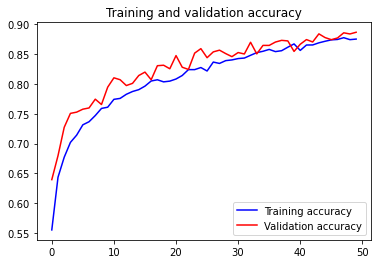

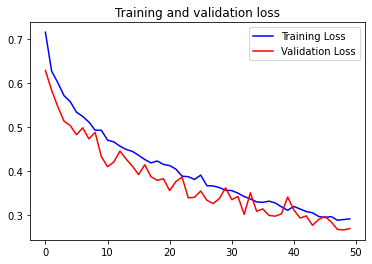

In [ ]:
plot_result(history)

### Test Data

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model('dogs-vs-cats.h5')

test_generator = ImageDataGenerator(rescale=1. / 255)

test_iterator = test_generator.flow_from_directory(
        '/Users/vanessaasaro/Desktop/Big data/test',
        target_size=(150, 150),
        shuffle=False,
        class_mode='binary',
        batch_size=1)

Found 4000 images belonging to 2 classes.


In [ ]:
model.evaluate(test_iterator)

4000/4000 [==============================] - 21s 5ms/step - loss: 0.2642 - accuracy: 0.8953


[0.2641962468624115, 0.8952500224113464]

In [ ]:
import cv2
import numpy as np

In [ ]:
test_imgs = []
files = os.listdir('/Users/vanessaasaro/Desktop/Big data/test 2/')
dim = (150, 150)
for filename in files:
    img = cv2.imread('/Users/vanessaasaro/Desktop/Big data/test 2/'+filename)
    img = cv2.resize(img,dim)
    test_imgs.append(img)

test_imgs = np.array(test_imgs)


In [ ]:
len(test_imgs)

12500

In [ ]:
test_imgs=test_imgs.astype("float32")/255.0

In [ ]:
result=model.predict(test_imgs)

In [ ]:
result

array([[0.01686001],
       [0.07826254],
       [0.9324323 ],
       ...,
       [0.05285367],
       [0.0043121 ],
       [0.8509111 ]], dtype=float32)

In [ ]:
rs=[]
SI=[]
name=[]
print(result.shape)
print(result.shape)
for i in range(0,result.shape[0]):
    rs.append(round(result[i][0]))
    if round(result[i][0]) == 1:
        name.append("dog")
    else:
        name.append("cat")
    SI.append(i)

(12500, 1)
(12500, 1)


In [ ]:
filenames = []
for filename in files:
    filenames.append(int(filename[:-4]))


In [ ]:
import pandas as pd

In [ ]:
output = pd.DataFrame( data={'filename':filenames,"Id":SI, "label":rs,"label_name":name} )

In [ ]:
print(output)

       filename     Id  label label_name
0          9733      0      0        cat
1            63      1      0        cat
2          6400      2      1        dog
3           823      3      1        dog
4          4217      4      1        dog
...         ...    ...    ...        ...
12495      3561  12495      0        cat
12496      8434  12496      1        dog
12497      7707  12497      0        cat
12498      6419  12498      0        cat
12499      1376  12499      1        dog

[12500 rows x 4 columns]


In [ ]:
output = output.sort_values(by=['filename'])

In [ ]:
output = output.reset_index(drop=True)

In [ ]:
output

,filename,Id,label,label_name
0,1,11768,1,dog
1,2,10969,1,dog
2,3,11663,1,dog
3,4,9385,0,cat
4,5,10128,0,cat
...,...,...,...,...
12495,12496,1157,0,cat
12496,12497,1212,0,cat
12497,12498,12131,1,dog
12498,12499,12077,1,dog


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
i = 1
images = []
predictions = []
for x in range(0,4000):
    filename = '/Users/vanessaasaro/Desktop/Big data/test 2/' + str(i) + '.jpg'
    i = i + 1
    images.append(mpimg.imread(filename))
    predictions.append(output.label_name[x])

Our prediction is: dog


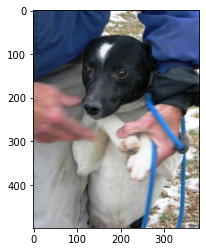

In [ ]:
plt.imshow(images[0])
print("Our prediction is:",predictions[0])

Our prediction is: dog


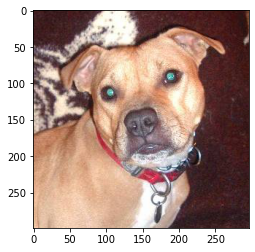

In [ ]:
plt.imshow(images[1])
print("Our prediction is:",predictions[1])

Our prediction is: dog


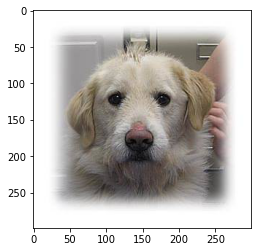

In [ ]:
plt.imshow(images[2])
print("Our prediction is:",predictions[2])

Our prediction is: cat


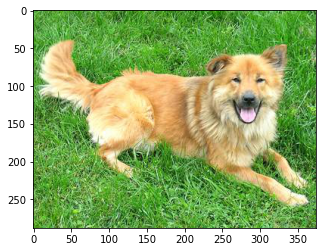

In [ ]:
plt.imshow(images[3])
print("Our prediction is:",predictions[3])

Our prediction is: cat


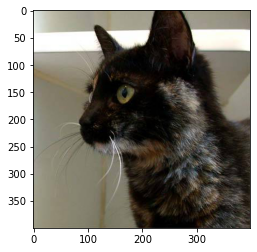

In [ ]:
plt.imshow(images[4])
print("Our prediction is:",predictions[4])

Our prediction is: cat


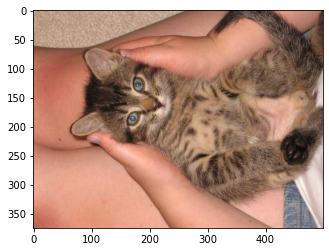

In [ ]:
plt.imshow(images[5])
print("Our prediction is:",predictions[5])

In [ ]:
names = []
entry = os.listdir('/Users/vanessaasaro/Desktop/Big data/test/dogs/')
for x in entry:
    names.append(x)
    #names.append(x.split('.')[0])

In [ ]:
for x in range(0,len(names)):
    if names[x] == '.DS_Store':
        print(x)
 

322


In [ ]:
del names[322]

In [ ]:
dog_files = []
for x in names:
    dog_files.append(int(x.split('.')[0]))

In [ ]:
dog_files.sort()

In [ ]:
cat_files = []
for x in range(1,4001):
    if x not in dog_files:
        cat_files.append(x)

In [ ]:
output_sub = output[0:4000]

In [ ]:
output_sub

,filename,Id,label,label_name
0,1,11768,1,dog
1,2,10969,1,dog
2,3,11663,1,dog
3,4,9385,0,cat
4,5,10128,0,cat
...,...,...,...,...
3995,3996,10034,1,dog
3996,3997,9479,1,dog
3997,3998,1705,0,cat
3998,3999,2236,1,dog


In [ ]:
real_label = []
for z in range(0,4000):
    if output_sub.filename[z] in dog_files:
        real_label.append(1)
    if output_sub.filename[z] in cat_files:
        real_label.append(0)

In [ ]:
len(real_label)

4000

In [ ]:
output_sub['real_label'] = real_label

<ipython-input-45-8128028effaf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_sub['real_label'] = real_label


In [ ]:
real_label_name = []
for z in range(0,4000):
    if output_sub.real_label[z] == 1:
        real_label_name.append('dog')
    if output_sub.real_label[z] == 0:
        real_label_name.append('cat')

In [ ]:
output_sub['real_label_name'] = real_label_name

<ipython-input-47-ecb515cb9a9e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_sub['real_label_name'] = real_label_name


In [ ]:
output_sub

,filename,Id,label,label_name,real_label,real_label_name
0,1,11768,1,dog,1,dog
1,2,10969,1,dog,1,dog
2,3,11663,1,dog,1,dog
3,4,9385,0,cat,1,dog
4,5,10128,0,cat,0,cat
...,...,...,...,...,...,...
3995,3996,10034,1,dog,1,dog
3996,3997,9479,1,dog,1,dog
3997,3998,1705,0,cat,1,dog
3998,3999,2236,1,dog,1,dog


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred = output_sub['label']
y_true = output_sub['real_label']
accuracy_score(y_true, y_pred)

0.82975

In [ ]:
accuracy_score(y_true, y_pred, normalize=False)

3319

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)

In [ ]:
import seaborn as sns

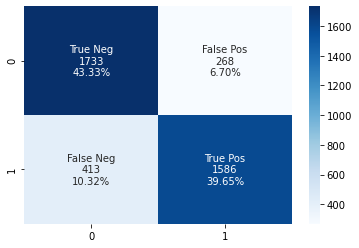

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
#Average f, precision and recall
avg_F = f1_score(y_true, y_pred, average='weighted')
avg_prec = precision_score(y_true, y_pred, average='weighted')
avg_recall = recall_score(y_true, y_pred, average='weighted')

In [ ]:
#Cat f, precision and recall
cat_prec = precision_score(y_true, y_pred, average=None, zero_division=1)[0]
cat_recall = recall_score(y_true, y_pred, average=None, zero_division=1)[0]
cat_F = f1_score(y_true, y_pred, average=None, zero_division=1)[0]


In [ ]:
#Dog f, precision and recall
dog_prec = precision_score(y_true, y_pred, average=None, zero_division=1)[1]
dog_recall = recall_score(y_true, y_pred, average=None, zero_division=1)[1]
dog_F = f1_score(y_true, y_pred, average=None, zero_division=1)[1]


In [ ]:
d = {'Measurement': ["Precision", "Recall","F Measure"], 
     'Cat':[cat_prec,cat_recall,cat_F],
     'Dog':[dog_prec,dog_recall,dog_F],
     'Average':[avg_prec,avg_recall,avg_F]}

In [ ]:
evals1 = pd.DataFrame(data=d)

In [ ]:
evals1

,Measurement,Cat,Dog,Average
0,Precision,0.807549,0.855448,0.831486
1,Recall,0.866067,0.793397,0.829750
2,F Measure,0.835785,0.823255,0.829523


In [ ]:
wrong_files = []
for x in range(0,4000):
    if output_sub.label[x] != output_sub.real_label[x]:
        wrong_files.append(x + 1)

In [ ]:
wrong_cat = output_sub[(output_sub["label"] == 1) & (output_sub["real_label"] == 0)]
wrong_dog = output_sub[(output_sub["label"] == 0) & (output_sub["real_label"] == 1)]


In [ ]:
wrong_dog.tail()

,filename,Id,label,label_name,real_label,real_label_name
3972,3973,1758,0,cat,1,dog
3973,3974,617,0,cat,1,dog
3983,3984,11548,0,cat,1,dog
3989,3990,11558,0,cat,1,dog
3997,3998,1705,0,cat,1,dog


In [ ]:
len(images)

2001

Our prediction is: cat


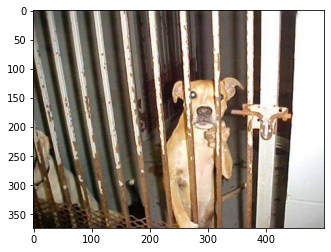

In [ ]:
plt.imshow(images[3997])
print("Our prediction is:",predictions[3997])

Our prediction is: cat


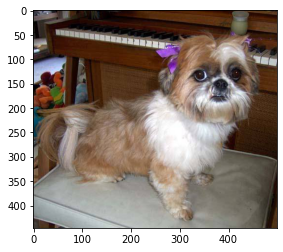

In [ ]:
plt.imshow(images[1999])
print("Our prediction is:",predictions[1999])